# FOPI index

In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import ipywidgets as widgets
from IPython.display import display, Markdown

## Set my directory

(since it has some problem to recognize the right path)

In [3]:
my_dir = os.getcwd()
print(my_dir)

C:\Users\CAPMAR00\OneDrive - IL Sole 24 Ore SpA\Documenti\marina\ecmwf\cfe-pyroscope\data-analysis


In [4]:
os.chdir(f"{my_dir}")

## Load the NetCDF file

‼️‼️‼️ The time values start normally (0, 3, 6, 9, etc. representing hours), but at the end there are extremely large scientific notation values like 5.52403880e+257, 2.66420808e+233, etc. 
‼️‼️‼️ Check with Christopher.‼️‼️‼️

In [6]:
ds = xr.open_dataset("fopi_2024120100.nc", decode_times=False)  # # Load without decoding times
ds

<xarray.Dataset>
Dimensions:           (time: 80, lon: 5136, lat: 2560)
Coordinates:
  * time              (time) float64 0.0 3.0 6.0 ... 2.102e-153 2.154e-57
  * lon               (lon) float64 0.0 0.07009 0.1402 ... 359.8 359.9 359.9
  * lat               (lat) float64 89.95 89.88 89.81 ... -89.81 -89.88 -89.95
Data variables:
    param100.128.192  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue May 13 11:48:51 2025: cdo -R -f nc -setgridtype,regular...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [7]:
print(ds['time'].units)

hours since 2024-12-1 00:00:00


In [8]:
print(ds['time'].values)

[0.00000000e+000 3.00000000e+000 6.00000000e+000 9.00000000e+000
 1.20000000e+001 1.50000000e+001 1.80000000e+001 2.10000000e+001
 2.40000000e+001 2.70000000e+001 3.00000000e+001 3.30000000e+001
 3.60000000e+001 3.90000000e+001 4.20000000e+001 4.50000000e+001
 4.80000000e+001 5.10000000e+001 5.40000000e+001 5.70000000e+001
 6.00000000e+001 6.30000000e+001 6.60000000e+001 6.90000000e+001
 7.20000000e+001 7.50000000e+001 7.80000000e+001 8.10000000e+001
 8.40000000e+001 8.70000000e+001 9.00000000e+001 9.30000000e+001
 9.60000000e+001 9.90000000e+001 1.02000000e+002 1.05000000e+002
 1.08000000e+002 1.11000000e+002 1.14000000e+002 1.17000000e+002
 1.20000000e+002 1.23000000e+002 1.26000000e+002 1.29000000e+002
 1.32000000e+002 1.35000000e+002 1.38000000e+002 1.41000000e+002
 1.44000000e+002 1.47000000e+002 1.50000000e+002 1.53000000e+002
 1.56000000e+002 1.59000000e+002 1.62000000e+002 1.65000000e+002
 1.68000000e+002 1.71000000e+002 1.74000000e+002 1.77000000e+002
 1.80000000e+002 1.830000

In [9]:
ds.data_vars

Data variables:
    param100.128.192  (time, lat, lon) float32 ...

In [10]:
variable_name='param100.128.192'

## Clean data

### Remove invalid/corrupted time values from dataset

In [89]:
def clean_time(ds, time_min=0, time_max=1e5):
    """
    Clean the 'time' coordinate by removing or fixing invalid or extreme values.
    
    Parameters:
    - ds: xarray.Dataset with 'time' coordinate as float.
    - time_min: minimum acceptable time value (inclusive).
    - time_max: maximum acceptable time value (inclusive).
    
    Returns:
    - ds with cleaned 'time' coordinate and corresponding data filtered.
    """
    # Get the time coordinate
    time = ds['time']
    
    # Create a mask for finite and valid times within the specified range
    valid_time_mask = time.where(
        # np.isfinite(time) filters out inf and -inf.
        # time.notnull() removes NaN.
        # The where(..., drop=True) call returns only valid time values.
        # sel(time=valid_time_mask['time']) ensures the dataset is sliced only at those valid times.
        time.notnull() & np.isfinite(time) & (time >= time_min) & (time <= time_max),
        drop=True
    )
    
    # Use the mask to filter the dataset
    ds_cleaned = ds.sel(time=valid_time_mask['time'])
    
    return ds_cleaned


In [91]:
ds_clean_time = clean_time(ds, time_min=0, time_max=200)

In [93]:
ds_clean_time

<xarray.Dataset>
Dimensions:           (time: 70, lon: 5136, lat: 2560)
Coordinates:
  * time              (time) float64 0.0 3.0 6.0 ... 2.102e-153 2.154e-57
  * lon               (lon) float64 0.0 0.07009 0.1402 ... 359.8 359.9 359.9
  * lat               (lat) float64 89.95 89.88 89.81 ... -89.81 -89.88 -89.95
Data variables:
    param100.128.192  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue May 13 11:48:51 2025: cdo -R -f nc -setgridtype,regular...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

### Remove infinite and NaN values

In [96]:
def mask_invalid_values_preserving_nan(ds):
    """
    Masks inf and NaN values in all data variables of the dataset.

    Parameters:
    - ds: xarray.Dataset

    Returns:
    - xarray.Dataset with invalid values masked (as NaN), preserving dataset structure.
    """
    ds_masked = ds.copy()

    for var in ds_masked.data_vars:
        data = ds_masked[var].values

        # Replace +inf/-inf with NaN (so they can be masked naturally)
        data = np.where(np.isinf(data), np.nan, data)

        # Assign masked data back
        ds_masked[var].values = data

    return ds_masked

def mask_invalid_values_dropping_nan(ds):
    """
    Masks inf and NaN values in all data variables using .where().

    Parameters:
    - ds: xarray.Dataset

    Returns:
    - xarray.Dataset where all inf and NaN values are masked (set to NaN).
    """
    ds_masked = ds.copy()

    for var in ds_masked.data_vars:
        valid_mask = np.isfinite(ds_masked[var].values)
        ds_masked[var] = ds_masked[var].where(valid_mask)

    return ds_masked

In [98]:
ds_final = mask_invalid_values_dropping_nan(ds_clean_time)

## EDA

**Basic Statistical Analysis**

1. Dataset overview (dimensions, coverage, resolution)
2. FOPI statistics (min, max, mean, std, median)
3. Data quality assessment (NaN counts)

In [100]:
def analyze_dataset(ds, variable_name=variable_name, extreme_threshold=1e+10):
    """
    Analyze a dataset with the given variable, accounting for NaNs, infs, and extreme fill values.
    """
    da = ds[variable_name]
    time_dim, lat_dim, lon_dim = da.sizes['time'], da.sizes['lat'], da.sizes['lon']
    total_values = time_dim * lat_dim * lon_dim

    # Flatten and convert to float64 for safe statistics
    data_flat = da.values.astype(np.float64).flatten()

    is_nan = np.isnan(data_flat)
    is_inf = np.isinf(data_flat)
    is_extreme = np.abs(data_flat) > extreme_threshold
    is_valid = ~(is_nan | is_inf | is_extreme)

    nan_count = int(np.sum(is_nan))
    inf_count = int(np.sum(is_inf))
    extreme_count = int(np.sum(is_extreme))
    valid_count = int(np.sum(is_valid))

    valid_data = data_flat[is_valid]

    stats = {
        'min': float(np.min(valid_data)) if valid_count > 0 else None,
        'max': float(np.max(valid_data)) if valid_count > 0 else None,
        'mean': float(np.mean(valid_data)) if valid_count > 0 else None,
        'std': float(np.std(valid_data)) if valid_count > 0 else None,
        'median': float(np.median(valid_data)) if valid_count > 0 else None,
        'percentiles': {
            '5th': float(np.percentile(valid_data, 5)),
            '25th': float(np.percentile(valid_data, 25)),
            '75th': float(np.percentile(valid_data, 75)),
            '95th': float(np.percentile(valid_data, 95)),
        } if valid_count > 0 else None
    }

    # Temporal coverage: valid values per timestep
    valid_mask_temporal = xr.apply_ufunc(lambda x: np.isfinite(x) & (np.abs(x) <= extreme_threshold), da)
    valid_per_time = valid_mask_temporal.sum(dim=["lat", "lon"]).values

    temporal_coverage = {
        'valid_per_time_min': int(valid_per_time.min()),
        'valid_per_time_max': int(valid_per_time.max()),
        'valid_per_time_mean': float(valid_per_time.mean()),
        'empty_time_steps': int(np.sum(valid_per_time == 0))
    }

    # Spatial coverage: pixels with at least one valid value over time
    valid_mask_spatial = valid_mask_temporal.sum(dim="time") > 0
    pixels_with_data = int(valid_mask_spatial.sum().values)
    total_pixels = lat_dim * lon_dim

    spatial_coverage = {
        'pixels_with_data': pixels_with_data,
        'total_pixels': total_pixels,
        'coverage_percentage': 100 * pixels_with_data / total_pixels
    }

    return {
        'statistics': stats,
        'data_quality': {
            'total_values': total_values,
            'valid_values': valid_count,
            'nan_values': nan_count,
            'inf_values': inf_count,
            'extreme_values': extreme_count,
            'valid_percentage': 100 * valid_count / total_values
        },
        'temporal_coverage': temporal_coverage,
        'spatial_coverage': spatial_coverage
    }

In [43]:
stats = analyze_dataset(ds_final)
stats

{'statistics': {'min': -9999863808.0,
  'max': 9999810560.0,
  'mean': 2275650.7094256496,
  'std': 208371911.14430943,
  'median': 0.0,
  'percentiles': {'5th': 0.0,
   '25th': 0.0,
   '75th': 0.14839686453342438,
   '95th': 0.7218136191368103}},
 'data_quality': {'total_values': 920371200,
  'valid_values': 199852213,
  'nan_values': 702688292,
  'inf_values': 0,
  'extreme_values': 17830695,
  'valid_percentage': 21.714305380263962},
 'temporal_coverage': {'valid_per_time_min': 2661868,
  'valid_per_time_max': 8412841,
  'valid_per_time_mean': 2855031.6142857145,
  'empty_time_steps': 0},
 'spatial_coverage': {'pixels_with_data': 12264392,
  'total_pixels': 13148160,
  'coverage_percentage': 93.27839028426791}}

## Data visualizations

### 1. Global map: FOPI at first, last, and time-averaged

In [101]:
def plot_global_fopi(ds, kind='first'):
    fopi = ds[variable_name]
    if kind == 'first':
        data = fopi.isel(time=0)
        title = 'FOPI - First Timestep'
    elif kind == 'last':
        data = fopi.isel(time=-1)
        title = 'FOPI - Last Timestep'
    elif kind == 'mean':
        data = fopi.mean(dim='time', skipna=True)
        title = 'FOPI - Time-Averaged'
    else:
        raise ValueError("kind must be one of ['first', 'last', 'mean']")
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='hot', cbar_kwargs={'label': 'FOPI'})
    ax.coastlines()
    ax.set_title(title)
    plt.show()

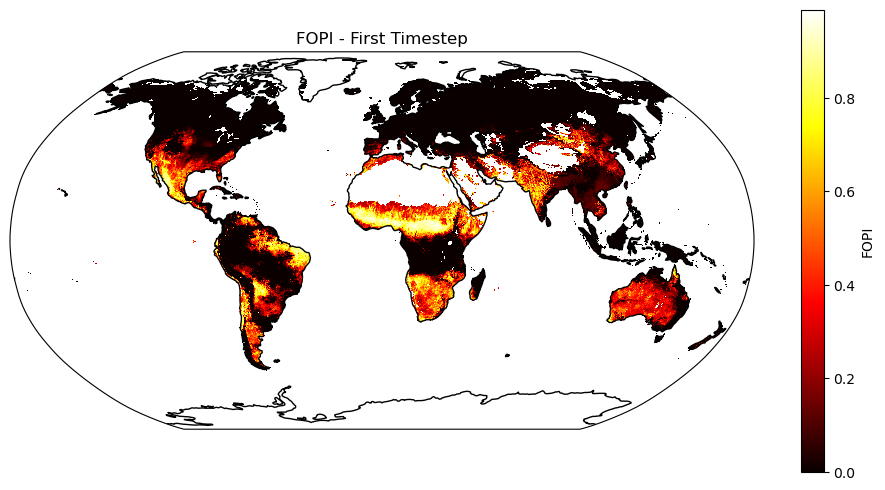

In [102]:
plot_global_fopi(ds_final)

### 2. Distribution: histogram of FOPI values

In [51]:
def plot_fopi_histogram(ds, bins=100):
    fopi = ds[variable_name]
    flat = fopi.values.flatten()
    valid = flat[~np.isnan(flat) & np.isfinite(flat) & (flat < 1e20)]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(valid, bins=bins, kde=False, color='darkred')
    plt.title('Histogram of FOPI Values')
    plt.xlabel('FOPI')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

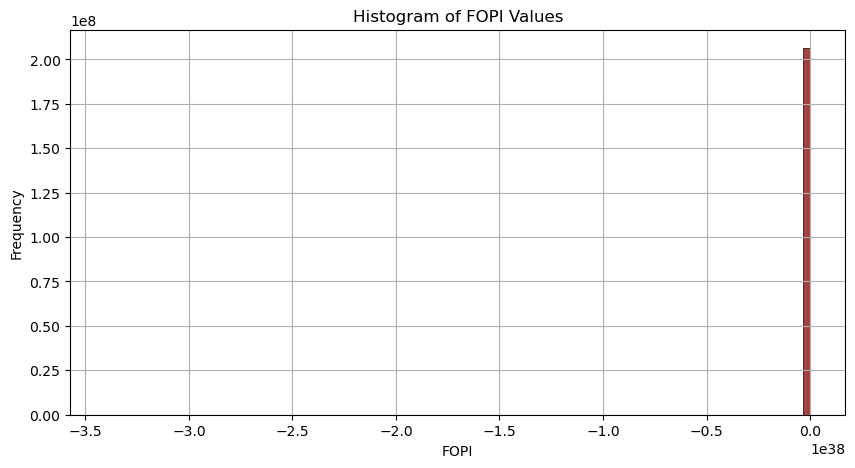

In [53]:
# plot_fopi_histogram(ds_final) it takes a lot of time

###  3. Temporal evolution: global mean FOPI over time

In [107]:
def plot_global_mean_fopi_over_time(ds):
    fopi = ds[variable_name]
    mean_fopi = fopi.mean(dim=['lat', 'lon'], skipna=True)
    
    plt.figure(figsize=(10, 5))
    mean_fopi.plot(marker='o', color='firebrick')
    plt.title('Global Mean FOPI Over Time')
    plt.xlabel('Time')
    plt.ylabel('Mean FOPI')
    plt.grid(True)
    plt.show()

C:\Users\CAPMAR00\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\CAPMAR00\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


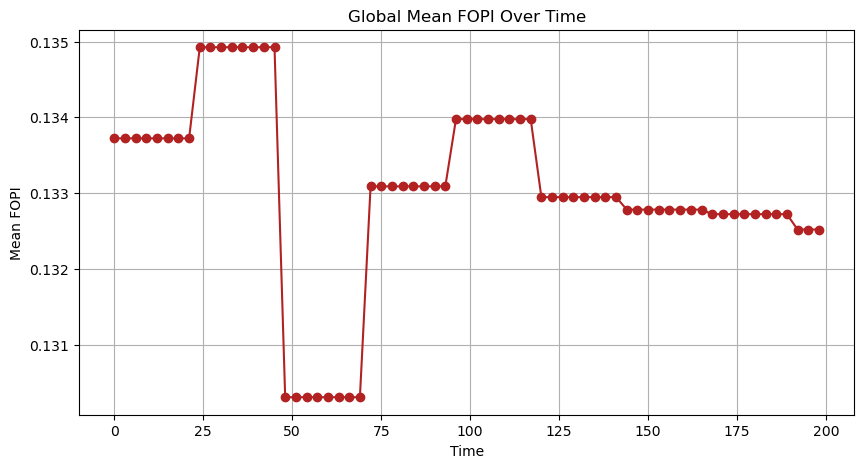

In [109]:
plot_global_mean_fopi_over_time(ds_final)

### 4. Regional focus: FOPI over Australia

In [111]:
def plot_fopi_over_australia(ds, time_idx=-1):
    if variable_name not in ds.data_vars:
        raise ValueError(f"Variable '{variable_name}' not found in dataset.")
    
    fopi = ds[variable_name].isel(time=time_idx)
    
    # Subset to Australia region
    fopi_region = fopi.sel(lat=slice(-10, -45), lon=slice(110, 155))  # lat must be decreasing in .sel()
    
    # Drop NaNs to avoid plotting failure
    fopi_region = fopi_region.where(np.isfinite(fopi_region), drop=False)
    
    if np.all(np.isnan(fopi_region)):
        print(f"No valid data to plot for time index {time_idx}. Skipping plot.")
        return
    
    # Plot
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    fopi_region.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='hot', cbar_kwargs={'label': 'FOPI'})
    ax.set_extent([110, 155, -45, -10], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'FOPI over Australia (time index: {time_idx})')
    plt.show()

C:\Users\CAPMAR00\AppData\Local\anaconda3\Lib\site-packages\matplotlib\colors.py:1370: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin
C:\Users\CAPMAR00\AppData\Local\anaconda3\Lib\site-packages\matplotlib\colors.py:1370: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin


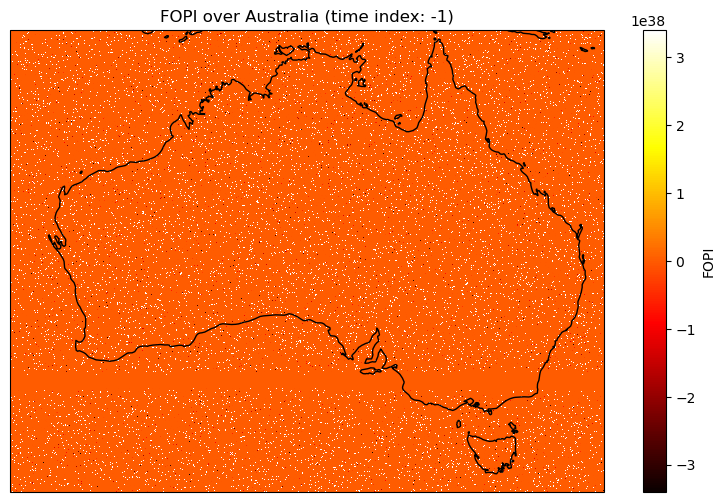

In [113]:
plot_fopi_over_australia(ds_final)

### 5. Latitudinal pattern: FOPI by latitude

In [116]:
def plot_latitudinal_fopi(ds):
    fopi = ds[variable_name]
    lat_mean = fopi.mean(dim=['time', 'lon'], skipna=True)

    plt.figure(figsize=(10, 5))
    plt.plot(ds['lat'], lat_mean, color='darkorange')
    plt.title('FOPI Variation by Latitude')
    plt.xlabel('Latitude')
    plt.ylabel('Mean FOPI')
    plt.grid(True)
    plt.show()

C:\Users\CAPMAR00\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\CAPMAR00\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


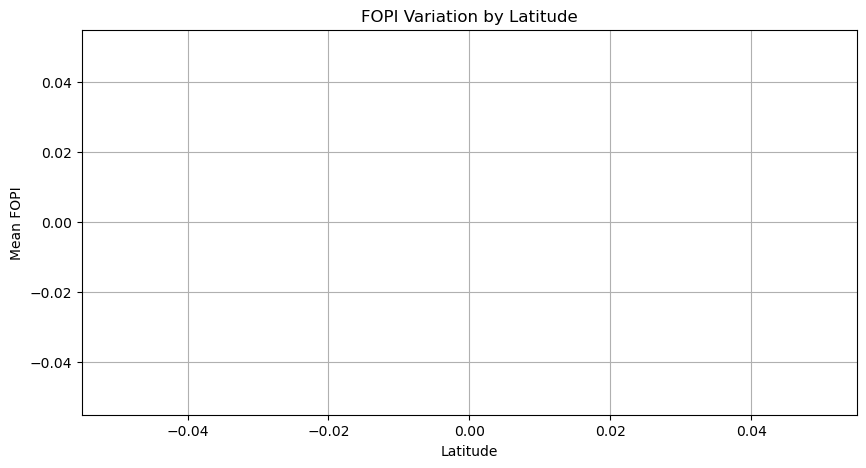

In [118]:
plot_latitudinal_fopi(ds_final)

### 6. Temporal variability: variance over time

In [120]:
def plot_temporal_variance(ds):
    fopi = ds[variable_name]
    var_fopi = fopi.var(dim='time', skipna=True)

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    var_fopi.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'FOPI Variance'})
    ax.coastlines()
    ax.set_title('Temporal Variance of FOPI')
    plt.show()

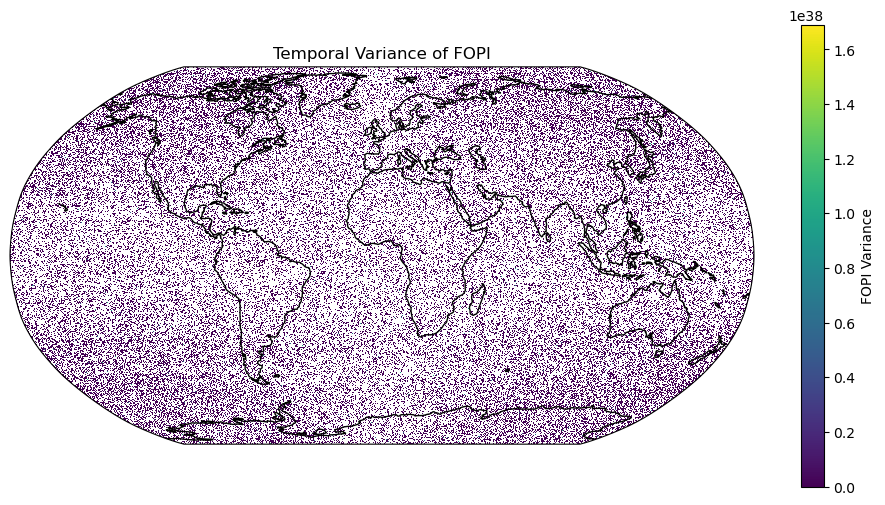

In [121]:
plot_temporal_variance(ds_final)

### 7. High-Risk Areas: Top 5% Fire Risk

In [123]:
def plot_top_5_percent_fire_risk(ds):
    fopi = ds[variable_name].mean(dim='time', skipna=True)
    threshold = np.nanpercentile(fopi, 95)
    high_risk = fopi.where(fopi >= threshold)

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    high_risk.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', cbar_kwargs={'label': 'FOPI'})
    ax.coastlines()
    ax.set_title('Top 5% Fire Risk Areas (Time-Averaged FOPI)')
    plt.show()

C:\Users\CAPMAR00\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


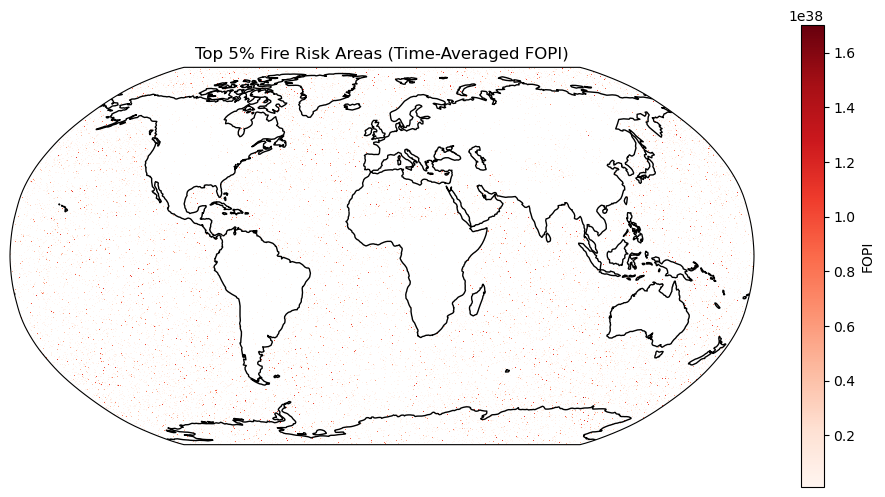

In [124]:
plot_top_5_percent_fire_risk(ds_final)